In [13]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, InputLayer, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [2]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [3]:
test_labels = np.argmax(y_test, axis=1)
train_labels = np.argmax(y_train, axis=1)

# Train model

In [4]:
load_mnist_model = True

In [5]:
filepath = './model_mnist/'  # change to directory where model is downloaded
if load_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=1,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    model.save(os.path.join(filepath, 'model.h5'))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Integrated gradients

In [6]:
n_steps = 50
method = "gausslegendre"
return_convergence_delta = False
return_predictions = False
ig  = IntegratedGradients(model, 
                          n_steps=n_steps, 
                          method=method,
                          return_convergence_delta=return_convergence_delta, 
                          return_predictions=return_predictions)

In [26]:
nb_samples = 10
bs = 10
X_test_red = X_test[:nb_samples]
test_labels_red = test_labels[:nb_samples]

In [27]:
explanation = ig.explain(X_test_red, 
                         baselines=None, 
                         target=test_labels_red, 
                         internal_batch_size=bs)

In [28]:
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['tensorflow', 'keras'],
 'explanations': ['local', 'global'],
 'params': {'n_steps': 50,
  'method': 'gausslegendre',
  'return_convergence_delta': False,
  'return_predictions': False}}

In [29]:
attributions = explanation.data['attributions']

# Visualize attributions

In [30]:
i = 0

True label 7


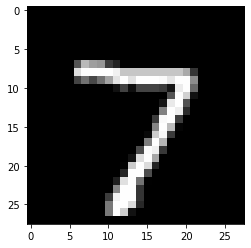

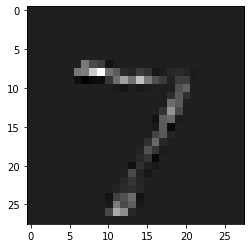

In [31]:
print('True label',test_labels[i])
plt.imshow(np.squeeze(X_test[i]), cmap='gray')
plt.show()
plt.imshow(np.squeeze(attributions[i]), cmap='gray')